This notebook is meant to aid in the determination of rough estimates for certain star-formation rate and metallicty parameters, namely the H-alpha SFR parameter and R23 and 12 + log(O/H) metallicity parameters. The determination of these parameters is almost wholly predicated on the calculation of integrated line fluxes, so all of the plotting and line fitting code from the spec_features notebook is included here, as well as some basic code for integrating over observed lines and calculating the aforementioned parameters. This notebook is still largely a work in progress, so feel free to adjust anything or add your own code for similar parameters/scientific calculations as well!

-Armaan Goyal

In [11]:
#import packages and set plotting style
import numpy as np
import scipy
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from scipy import optimize as op
from scipy import signal as sig
from scipy.ndimage.filters import gaussian_filter1d
plt.style.use(astropy_mpl_style)
from astropy.stats import sigma_clipped_stats
from scipy.interpolate import interp1d

def data_from_text(filename):
    data = np.genfromtxt(filename, usecols = (0, 1))
    wav, flux = np.split(data, 2, axis = 1)
    flux = np.reshape(flux, len(flux))
    wav = np.reshape(wav, len(wav))
    return wav, flux

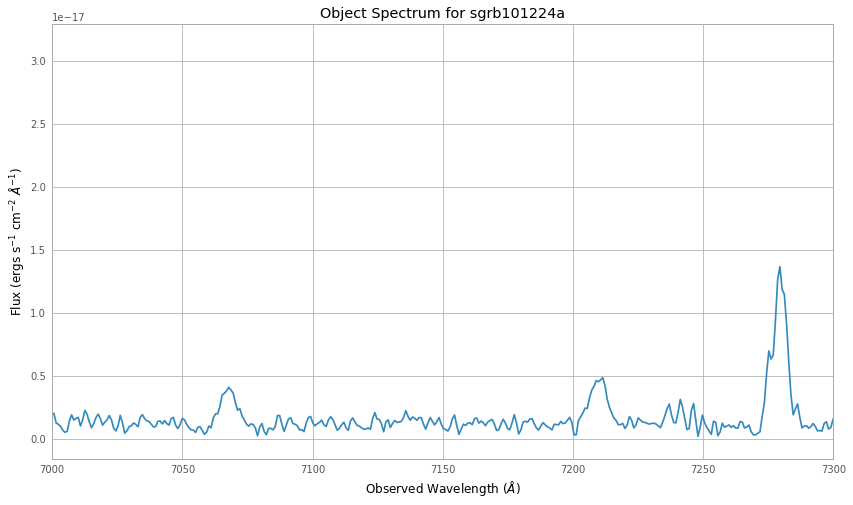

In [3]:
def plot_data(filename, **kwargs):
    fig = plt.figure(figsize=(14,8)) 
    wav, flux = data_from_text(filename)
    x_lim = kwargs.get("x_lim", None)
    y_lim = kwargs.get("y_lim", None)
    plt.plot(wav, flux)
    plt.ylabel("Flux (ergs s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)")
    plt.xlabel("Observed Wavelength ($\AA$)")
    if x_lim:
        plt.xlim(x_lim[0], x_lim[1])
    if y_lim:
        plt.ylim(y_lim[0], y_lim[1])
    plt.title("Object Spectrum for sgrb101224a")
    plt.show()

plot_data("sgrb101224a_ext", x_lim = (7000, 7300))

The following is code for semi-automatic line fitting, and includes routines for both Lorentizan and Gaussian line modeling as well as for Gaussian filter and Savitsky-Golay smoothing to make the fitting process easier. This task is the main method for determining the locations of features in the data, but it requires a fair amount of manual input. It is best to use the previous task to get an estimate of the plotting window and line location, and then performing multiple passes with different fitting windows to best capture the endpoints of the line.

In [4]:
#define profiles for fitting

def gaussian(x, a, mu, sigma):
    return a*np.exp(-1*((x-mu)**2)/(2*sigma**2))

def lorentzian(x, a, x0, gamma):
    return a/(1 + ((x - x0)/(gamma/2))**2)

def line_fitting(filename, fit_type, fit_window, g, x_lim, y_lim, **kwargs):
    '''
    Attempts to determine line profile of emission features by smoothing and fitting to either a Gaussian or Lorentzian.
    
    Parameters:
    -----------
    filename (str): name of input file
    fit_type (str): type of profile to use for fitting, input "g" for Gaussian or "l" for Lorentzian
    fit_window (tuple of ints): endpoints of feature to be fit, should determined conservatively (limit strictly to line profile)
    g (tuple of floats and ints): tuple of initial guesses for line profile parameters in form of (height, center, half-width)
    x_lim (tuple of ints): x-window of plot
    y_lim (tuple of ints): y-window of plot
    
    Optional Parameters:
    --------------------
    smooth (str): type of smoothing (if desired), "g" for Gaussian and "sg" for Savitzky-Golay
    poly_order (int): Use only if smooth = "sg". Order of SG smoothing polynomial.
    window (tuple of ints): Use only if smooth = "sg". Window size for SG smoothing, must be odd and greater than poly_order.
    sigma (float): Use only if smooth = "g". Std. dev. of Gaussian smoothing filter.
    
    Returns:
    --------
    Plots data and smoothed data with best-fit profile. Prints and returns tuple of model parameters.
    
    '''
    fig = plt.figure(figsize=(14,8)) 
    data = np.genfromtxt(filename, usecols = (0, 1))
    wav, flux = np.split(data, 2, axis = 1)
    flux = np.reshape(flux, len(flux))
    wav = np.reshape(wav, len(wav))
    sm = kwargs.get("smooth", None)
    sg_window = kwargs.get("window", 15)
    sg_order = kwargs.get("poly_order", 3)
    g_sigma = kwargs.get("sigma", 2)
    plt.plot(wav, flux, label = "Flux-Calibrated Spectrum")
    if sm == "sg":
        flux = sig.savgol_filter(flux, sg_window, sg_order)
        plt.plot(wav, flux, ls = "--", label = "SG Smoothed Data for %s"%filename)
        print("Savitzky-Golay filter applied with window size %d and polynomial order %d"%(sg_window, sg_order))
    if sm == "g":
        flux = gaussian_filter1d(flux, g_sigma)
        plt.plot(wav, flux, ls = "--", label = "Gaussian Smoothed Data for %s"%filename)
        print("Gaussian Filter applied with std. dev. %.1f"%(g_sigma))
    lim = (wav > fit_window[0]) & (wav < fit_window[1])
    (wav_sub, flux_sub) = (wav[lim], flux[lim])
    if fit_type == "g":
        popt, pcov = op.curve_fit(gaussian, wav_sub, flux_sub, p0=[g[0], g[1], g[2]])
        plt.plot(wav_sub, gaussian(wav_sub, popt[0], popt[1], popt[2]), label = "Gaussian Fit for Trace")
        print("Line fit to Gaussian with amplitude %1.20f, center at %.2f angstroms and std. dev. %.2f angstroms"%(popt[0], popt[1], popt[2]))
    if fit_type == "l":
        popt, pcov = op.curve_fit(lorentzian, wav_sub, flux_sub, p0=[g[0], g[1], g[2]])
        plt.plot(wav_sub, lorentzian(wav_sub, popt[0], popt[1], popt[2]), label = "Lorentzian Fit for Trace")
        print("Line fit to Lorentzian with amplitude %1.20f, center at %.2f angstroms, and gamma of %.2f angstroms"%(popt[0], popt[1], popt[2]))
    plt.ylabel('Flux')
    plt.xlabel('Wavelength (Angstroms)')
    plt.xlim(x_lim[0], x_lim[1])
    plt.ylim(y_lim[0], y_lim[1])
    plt.title("Line Profile Fitting for Feature at %.2f Angstroms"%popt[1])
    plt.legend()
    plt.show()
    return popt

Just as in the spec_features notebook, we can use the line fitting code (or splot) to determine models for features in our observed data, only now we may directly save the output of line_fitting as the parameter vector for our integration in the next steps (we will also need the fitting window to determine limits of integration). We will once again use the example of this O III line, which ranges from aabout 7770 to 7290 angstroms, saving the model parameters as f_oiii.

Gaussian Filter applied with std. dev. 1.0
Line fit to Lorentzian with amplitude 0.00000000000000001286, center at 7279.46 angstroms, and gamma of -6.53 angstroms


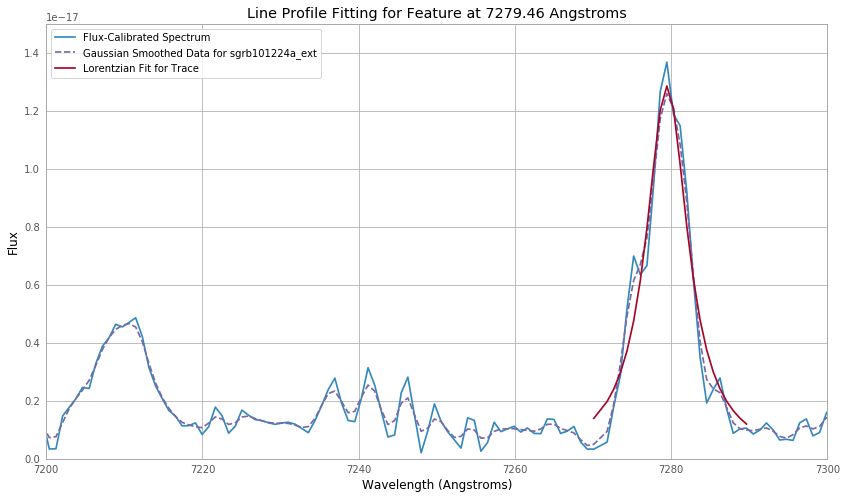

In [9]:
filename = "sgrb101224a_ext"

#fitting parameters
fit_type = "l" #l for lorentzian, g for gaussian
initial_guess = (1.5*10**(-18), 7270, 10) #formatted as (height, center, width)
fit_window = (7270, 7290) #determining these bounds will probably require some guess-and-check, should be the edges of the line profile

#plotting
x_window = (7200, 7300)
y_window = (0, 1.5*(10**-17))

#smoothing
smooth = "g"

#if Gaussian smoothing
sigma = 1

#if SG smoothing
#sg_window = 
#poly_order = 

oiii = line_fitting(filename, fit_type, fit_window, initial_guess, x_window, y_window, smooth = "g", sigma = sigma)

We may now use these parameters and the fitting window from before to determine the integrated line flux for this line. One should also specify if the model being used is a Gaussian or Lorentizan profile.

In [12]:
def integrated_flux(function, params, low, high):
    '''
    Parameters:
    -----------
    function (function): type of model used, type either lorentzian or gaussian (not as a string)
    params (tuple of float): parameter vector as determined by line_fitting, in form of (height, center, width)
    low/high (float): limits of integration, should be roughly the same as fit_window parameter in line_fitting task
    
    Returns:
    --------
    Value of integrated line flux over the given model and bounds
    
    '''
    f = lambda x: function(x, params[0], params[1], params[2])
    return scipy.integrate.quad(f, low, high)[0]
    
f_oiii = integrated_flux(lorentzian, oiii, 7270, 7290)
print(f_oiii)

1.0534618620838194e-16


This process can be repeated for all lines that appear in the data, and their line fluxes can be used to calculate the parameters below (depending on which of the relevant lines can be found).

For calculation of the H-alpha SFR parameter, a luminosity distance is required as input, and one can obtain this at http://www.astro.ucla.edu/~wright/CosmoCalc.html by inputting the spectrum redshift and clicking the "general" button on the calculator.
    
Note also that for all calculations that require an integrated line flux for O III, this value is actually the sum of the integrated line fluxes for both lines of the O III doublet ($\lambda$4960 and $\lambda$5008 angstroms in the rest frame).

In [1]:
def SFR_Halpha(f_Ha, DL):
    coeff = 7.9e-42
    DL_cm = DL*(3.086e24)
    L = 4*np.pi*(DL_cm**2)*f_Ha
    return coeff*L

def R23(f_oii, f_oiii, f_Hb):
    return (f_oii + f_oiii)/f_Hb

def log_OH(f_oiii, f_Hb, f_nii, f_Ha):
    num = f_oiii/f_Hb
    denom = f_nii/f_Ha
    return 8.73 - 0.32*np.log10(num/denom)